# Example of factorizing quantum linear systems with time-delayed feedback

In this notebook degeneracies are handled by perturbing pole locations using a phase shift

In [3]:
import numpy
from numpy import linalg as la

import sympy
from sympy import init_printing
init_printing()

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
## We use some functions from https://github.com/tabakg/potapov_interpolation

import sys
P_dir = '/Users/gil/Google Drive/repos/potapov/potapov_interpolation/Potapov_Code/'
sys.path.append(P_dir)
import Roots
from Potapov import get_Potapov_vecs
from functions import der
from functions import limit

In [9]:
import utils
reload(utils)

from utils import(
    double_up,
    J,
    flat,
    make_ABCD,
    make_T,
    scale_vector_doubled_up,
    real_scaling,
    make_Sigma,
    check_J_unitary,
    check_doubled_up_func,
    check_doubled_up_mat,
    purge,
    complex_prod_deg,
    factorize_complex_poles,
    factorize_real_poles,
    factorize_deg_real_pole,
    make_Jv,
    make_Sigma,
    get_squeezed_spectrum
)

## Symbols we will use for the construction.

In [6]:
r, kappa, eps, z = sympy.symbols('r kappa epsilon z')

## Generate a specific system from Example VI.1 : Enhanced squeezing via coherent feedback from page 31 of https://arxiv.org/pdf/1611.00375.pdf with added time delay.

## Example 1, using eq. 122 in the example, i.e. the squeezer and the beamsplitter are in series, but *the feedback loop has not been closed*. There are two inputs and two outputs.

In [10]:
Omega_p = sympy.Matrix([1j*eps])
Omega_m = sympy.zeros(1)
Omega = double_up(Omega_p,Omega_m, second_row_minus=True)

Phi_p = sympy.zeros(2,1)
Phi_m = sympy.zeros(2,1)
Phi_m[0,0] = -sympy.sqrt(1-r**2)*sympy.sqrt(kappa)
Phi_m[1,0] = r*sympy.sqrt(kappa)
Phi = double_up(Phi_p,Phi_m)

S = sympy.Matrix([[-sympy.sqrt(1-r**2),r],[r,sympy.sqrt(1-r**2)]])

The $A,B,C,D$ matrices are constructed using:

\begin{align*}
\tilde \Phi &= \begin{pmatrix}
\Phi_- && \Phi_+ \\
\Phi_{+}^* && \Phi_{-}^*
\end{pmatrix} \\ 
\tilde \Omega &= \begin{pmatrix}
\Omega_- && \Omega_+ \\
-\Omega_{+}^* && -\Omega_{-}^*
\end{pmatrix}
\end{align*}
 
\begin{align*}
\tilde A = - \frac{1}{2} \tilde\Phi^\flat \tilde \Phi - i \tilde \Omega, &&
\tilde B = -\tilde \Phi^\flat \tilde D, \\
\tilde C = \tilde \Phi, && \tilde D = \begin{pmatrix}
S & 0 \\ 0 & S^*
\end{pmatrix}.
\end{align*}

In [11]:
A,B,C,D = make_ABCD(S,Phi,Omega)

In [14]:
T_z = make_T(A,B,C,D,z)

## Testing numerical values

$T(z)$ Should satisfy the J-unitary property when $z$ is purely imaginary

In [15]:
T_z_num = T_z.subs({kappa:1., r:0.6, eps:0.2}).expand()

In [16]:
T = sympy.lambdify( (z), T_z_num)

In [17]:
M = A.shape[0]/2
N = D.shape[0]/2
JA = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
JD = numpy.matrix(numpy.diag([1 for i in range(N)]+[-1 for i in range(N)]))

In [18]:
all([check_J_unitary(T, i*1j) for i in range(-10,10)])

True

## Root finding

In [19]:
T_det = lambda z: 1./la.det(T(z))
# T_det_der = lambda z: der(T_det,z)
# poles = Roots.get_roots_rect(T_det, T_det_der, 0.,0.,5.,5.,N=10)

In [20]:
poles = []

for i in numpy.linspace(-2,2,10):
    for j in numpy.linspace(-2,2,10):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_det)
        poles.append(p)

In [21]:
significant_poles = Roots.purge(poles, eps = 1e-1)
significant_poles

[(-0.69999997458577368-1.4763517448691094e-08j),
 (-0.29999857274625263-4.7636200239888787e-06j)]

In [22]:
significant_poles = [p.real for p in significant_poles]

## Factorize function

In [23]:
J2 = numpy.matrix(numpy.diag([1,1,-1,-1]))

In [24]:
vecs = get_Potapov_vecs(T,[s for s in significant_poles])
u1, u2 = vecs

w1 = scale_vector_doubled_up(u1)
w2 = scale_vector_doubled_up(u2)
v1, v2 = real_scaling(w1, w2)
if (v1.H*J2*v2).imag < 0:
    v1, v2 = v2, v1
    significant_poles.reverse()
U = numpy.matrix([[1,1],[-1j,1j]])
V = numpy.hstack([v1,v2])*U
V_flat = JA*V.H*JD

In [25]:
## Check V is doubled-up
check_doubled_up_mat(V)

True

## We should have $I = V^\flat*V$ and $P_v = V*V^\flat$ should be a projector.

In [26]:
Pv = V*V_flat

In [27]:
## Check V_flat * V is close the I.
print la.norm(V_flat*V - numpy.matrix(numpy.eye(2)))

2.86102351452e-07


In [28]:
## Check Pv is a projector.
print la.norm(Pv - Pv**2)

2.86102351434e-07


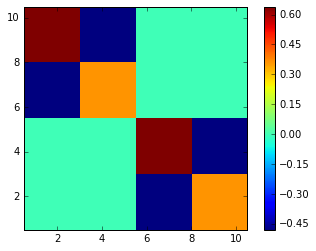

In [29]:
## Check what the projection looks like
plt.imshow((V*V_flat).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

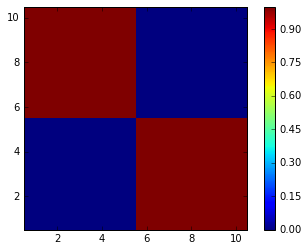

In [30]:
plt.imshow((V_flat*V).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

In [31]:
## Construct factors for real roots.

F1 = lambda z: (numpy.matrix([[(z + significant_poles[1])/(z-significant_poles[0]), 0],
                            [0, (z + significant_poles[0])/(z-significant_poles[1])]])
                )

T_factorized_1 = lambda z: numpy.matrix(numpy.eye(D.shape[0])) - V*V_flat + V*la.inv(U)*F1(z)*(U)*V_flat

B_constant = T(1e12)*la.inv(T_factorized_1(1e12))

fact1 = lambda z: (B_constant*T_factorized_1(z)).T

### Ensure the generated factor is J-unitary and doubled-up

In [32]:
T_factorized_1(10j)*J2*T_factorized_1(10j)-J2

matrix([[ -1.27260945e-02 +1.26993874e-01j,
           9.54457545e-03 -9.52454433e-02j,
          -9.13770208e-10 -5.49769808e-11j,
           6.85327656e-10 +4.12327355e-11j],
        [  9.54457394e-03 -9.52454434e-02j,
          -7.15843387e-03 +7.14341109e-02j,
          -1.20702503e-09 -1.48400490e-10j,
           9.05268769e-10 +1.11300368e-10j],
        [  9.02889348e-10 +1.27071007e-10j,
           1.21518567e-09 +9.43299548e-11j,
           1.27260927e-02 -1.26993874e-01j,
          -9.54456954e-03 +9.52454056e-02j],
        [ -6.77167012e-10 -9.53032545e-11j,
          -9.11389254e-10 -7.07474669e-11j,
          -9.54456954e-03 +9.52454056e-02j,
           7.15842716e-03 -7.14340542e-02j]])

In [33]:
J2 = numpy.matrix(numpy.diag([1,1,-1,-1]))

In [34]:
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Check the factor equals the original transfer function

In [35]:
def plot_T_and_fact(T, fact1, z):
    plt.title("Original transfer function, real part.")
    plt.imshow((T(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, real part.")
    plt.imshow((fact1(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("Original transfer function, imaginary part.")
    plt.imshow((T(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, imaginary part.")
    plt.imshow((fact1(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

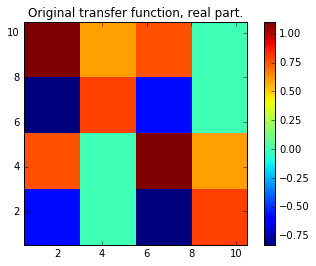

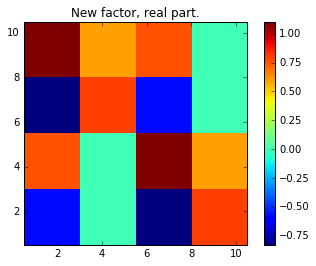

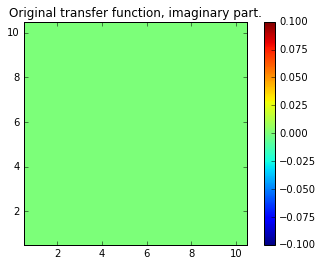

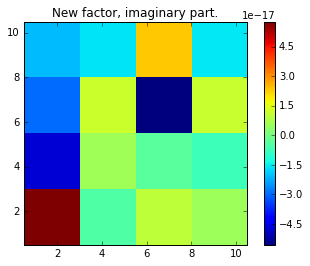

In [36]:
plot_T_and_fact(T, fact1, 0)

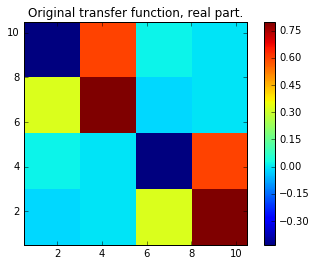

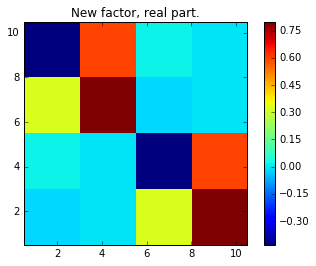

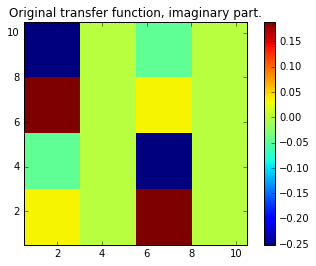

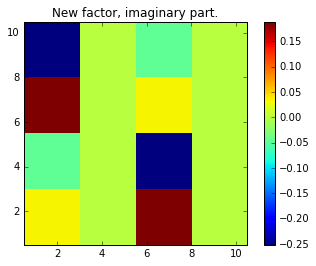

In [37]:
plot_T_and_fact(T, fact1, 1j+1.)

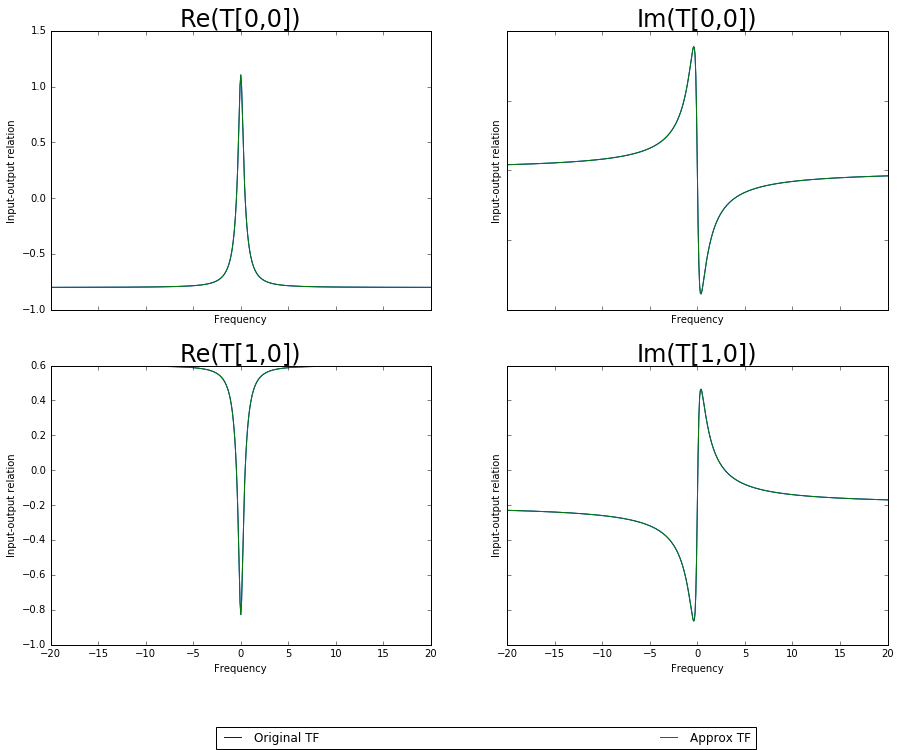

In [38]:
xr = numpy.linspace(-20,20,501)
xr_im = xr*1j
yr = numpy.array(map(T, xr_im))
zr = numpy.array(map(fact1, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(15,11))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )


f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

## Example 2. Next we close the feedback loop with a time delay and

### Feedback operation

In [39]:
T_old = sympy.lambdify(z, T_z_num)

In [40]:
P = numpy.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

In [41]:
P

matrix([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

In [42]:
T_o = P*T_z_num*P

In [43]:
T1 = sympy.lambdify(z, T_o[0:2,0:2])

In [44]:
T2 = sympy.lambdify(z, T_o[0:2,2:4])

In [45]:
T3 = sympy.lambdify(z, T_o[2:4,0:2])

In [46]:
T4 = sympy.lambdify(z, T_o[2:4, 2:4])

### Check some properties that should be true

In [47]:
Jv = numpy.matrix([[1,0],[0,-1]])

In [48]:
print la.norm(T1(0)*Jv*T1(0).H +T2(0)*Jv*T2(0).H - Jv) < 1e-5

True


In [49]:
print la.norm(T1(0)*Jv*T3(0).H +T2(0)*Jv*T4(0).H) < 1e-5

True


In [50]:
print la.norm(T3(0)*Jv*T3(0).H +T4(0)*Jv*T4(0).H - Jv) < 1e-5

True


In [51]:
I = numpy.matrix(numpy.eye(2))

### Feedback without time delay

In [52]:
T_tilde_0 = lambda z: T1(z) + T2(z)*la.inv(I - T4(z))* T3(z)

In [53]:
print all([[check_J_unitary(T_tilde_0,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde_0,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Feedback with time delay

In [54]:
t = 2

In [55]:
delta = 1e-3 ## Phase shift

In [56]:
E = lambda z: numpy.matrix(numpy.diag(numpy.exp([delta*1j-t*z, -delta*1j-t*z])))

In [57]:
T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)

In [58]:
print all([[check_J_unitary(T_tilde,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [59]:
T_tilde(1+1j)


matrix([[-0.43178873-0.28052089j,  0.02134243-0.04627353j],
        [ 0.02134369-0.04626821j, -0.43173370-0.28052584j]])

In [60]:
T_tilde(1-1j)


matrix([[-0.43173370+0.28052584j,  0.02134369+0.04626821j],
        [ 0.02134243+0.04627353j, -0.43178873+0.28052089j]])

### Plot of input-output function

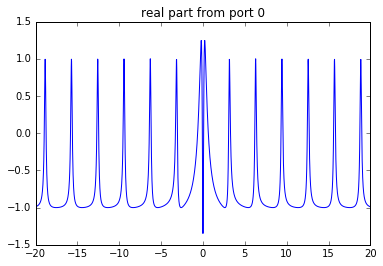

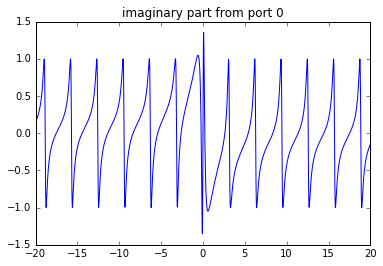

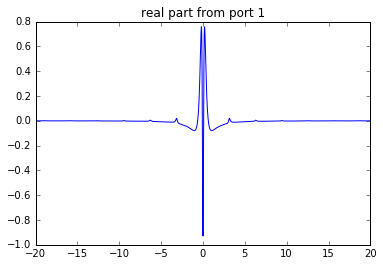

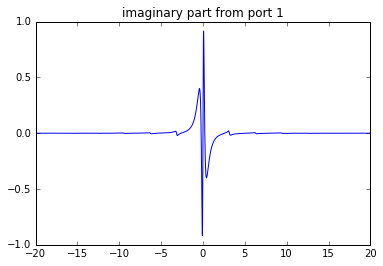

In [72]:
xr = numpy.linspace(-20,20,2000)
yr = numpy.array(map(T_tilde, xr*1j))

for i in range(yr.shape[1]):
    plt.title("real part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].real)
    plt.show()
    plt.title("imaginary part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].imag)
    plt.show()

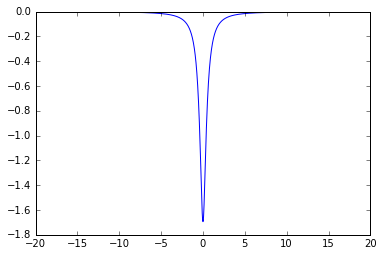

In [73]:
## Analysis of squeezing spectrum.

PP = get_squeezed_spectrum(yr)
plt.plot(xr, -PP)

## Next, find the roots for $\tilde T(z)$.

In [67]:
T_tilde_det = lambda z: 1./la.det(T_tilde(z))

### The method above didn't work well, so we use grid + Muller search.

In [68]:
poles_tilde = []

for i in numpy.linspace(-5,5,100):
    for j in numpy.linspace(-5,5,100):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_tilde_det)
        poles_tilde.append(p)

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/gil/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [69]:
poles_tilde = numpy.asarray(purge(Roots.inside_boundary(poles_tilde, 0., 0., 10., 10.), 1e-1))

In [70]:
poles_tilde

array([-0.11179577 -3.14122784e+00j, -0.11194000 +6.28310857e+00j,
       -0.70000451 +1.10532254e-06j, -0.30000900 -1.40997424e-05j,
       -0.11198972 +3.14218987e+00j, -0.11208258 -3.06929607e-04j,
       -0.11194000 -6.28310857e+00j, -0.11155626 +9.42432898e+00j,
       -0.11155626 -9.42432898e+00j])

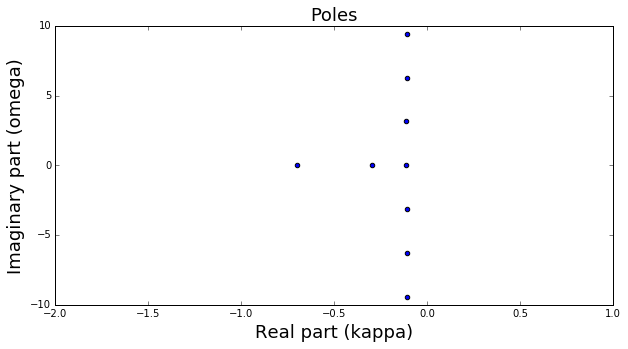

In [71]:
plt.figure(figsize=(10,5))
plt.scatter(poles_tilde.real,poles_tilde.imag, )
plt.title("Poles", fontsize=18)
plt.xlim(-2,1)
plt.ylim(-10,10)
plt.xlabel("Real part (kappa)", fontsize=18)
plt.ylabel("Imaginary part (omega)", fontsize=18)

### Organize the poles into different categories

In [74]:
real_cutoff = 1e-4

In [75]:
complex_poles = [p for p in poles_tilde if abs(p.imag) >= real_cutoff]

In [76]:
real_poles = [p.real for p in poles_tilde if abs(p.imag) < real_cutoff]

In [77]:
pos_complex_poles = [p for p in complex_poles if p.imag > real_cutoff]

In [78]:
neg_complex_poles =  [p for p in complex_poles if p.imag < -real_cutoff]

In [79]:
pos_complex_poles

[(-0.11193999818059153+6.2831085749751212j),
 (-0.11198971556738929+3.1421898670934394j),
 (-0.11155625788668919+9.4243289815171334j)]

In [80]:
neg_complex_poles

[(-0.11179577041483077-3.1412278388979087j),
 (-0.11208257822408982-0.00030692960745756786j),
 (-0.11193999818011889-6.2831085749746816j),
 (-0.11155625788693897-9.4243289815173412j)]

In [81]:
complex_poles.sort(key=lambda z: z.imag)

In [82]:
every_other1 = [p for i,p in enumerate(complex_poles) if i%2 == 0]

In [83]:
every_other1

[(-0.11155625788693897-9.4243289815173412j),
 (-0.11179577041483077-3.1412278388979087j),
 (-0.11198971556738929+3.1421898670934394j),
 (-0.11155625788668919+9.4243289815171334j)]

### Factorize the (degenerate) complex poles

In [84]:
which_poles = complex_poles

In [86]:
## Print the unperturbed vectors. They are degenerate when v.H*J*v = 0.
which_vecs = factorize_complex_poles(which_poles, T_tilde, verbose=False, eps = 0.)

In [87]:
T_c = lambda z: complex_prod_deg(z, which_poles, which_vecs, 2, eps = 0)

In [88]:
### Check the resulting function is J-unitary and doubled-up.

In [89]:
print all([[check_J_unitary(T_c,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_c,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [90]:
### The example has both degenerate and non-degenerate real poles 
### They are seperated below.

In [91]:
deg_cutoff = 1e-3
deg_real_poles = []
non_deg_real_poles = []

for pole in real_poles:
    L = limit(lambda z: (z+pole)*T_tilde(z),pole, N=1000, eps=deg_cutoff*deg_cutoff)
    vals, vecs = la.eig(L)
    index = np.argmax(map(abs,vals))
    u = vecs[:,index] ## vector to be used in case of 1-dim eigenspace
    
    ## Make Sigma
    sub_sigma = numpy.diag([1]*(u.shape[0]/2))
    M = u.shape[0]/2
    Sigma = numpy.vstack((
                numpy.hstack((np.zeros((M,M)),sub_sigma)),
                numpy.hstack((sub_sigma,np.zeros((M,M))))
            ))

    print ("The eigenspace will have dimension > 1 if a vector cannot be rescaled such u = Sigma*u.conj().")
    print pole, la.norm(u - Sigma*u.conj())

    if la.norm(u - Sigma*u.conj()) > deg_cutoff:
        non_deg_real_poles.append(pole)
    else:
        deg_real_poles.append(pole)        
        

The eigenspace will have dimension > 1 if a vector cannot be rescaled such u = Sigma*u.conj().
-0.700004509136 1.99999996006
The eigenspace will have dimension > 1 if a vector cannot be rescaled such u = Sigma*u.conj().
-0.300009000184 0.00280409574017


In [92]:
non_deg_real_poles

In [93]:
deg_real_poles

In [94]:
### Assume there are only two degenerate poles. Pair them together

In [95]:
p1, p2 = non_deg_real_poles
# p3 = deg_real_poles[0]

In [96]:
### Factor out the non-degenerate poles.
T_factorized_1 = factorize_real_poles(p1, p2, T_tilde)

In [97]:
### Check J-unitary and doubled-up properties.
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [98]:
### Detach the factor T_factorized_1
T_tilde_2 = lambda z: T_tilde(z)*la.inv(T_factorized_1(z))

### Check to see poles are removed

In [99]:
## Values should be large near a pole
T_tilde(p1+1e-5)

matrix([[ 132081.89267918+26.39577216j, -132086.96956619-26.39678675j],
        [-132086.96956619+26.39678675j,  132081.89268410-26.39577216j]])

In [100]:
## Values should be O(1).
T_tilde_2(p1+1e-5)

matrix([[-2.04608351-10.60772907j,  0.59983550-10.60749017j],
        [ 0.59983619+10.60749017j, -2.04608282+10.60772907j]])

In [101]:
## Values should be large near a pole
T_tilde(p2+1e-5)

matrix([[ 1116798.33520368+1565.951658j  ,  1116794.98568747+1565.94696138j],
        [ 1116794.98568747-1565.94696138j,  1116798.33540927-1565.95165829j]])

In [102]:
## Values should be O(1).
T_tilde_2(p2+1e-5)

matrix([[-12.03398903-148.80262386j, -10.21822419+148.77079462j],
        [-10.21815553-148.77079471j, -12.03405769+148.80262399j]])

### Generate and plot the factorized functions.

In [107]:
z0 = 0 ## Point at which we specify the new function should equal the original.
T_fact = lambda z: (T_tilde(z0)
                  #  * la.inv(T_factorized_2(z0))*T_factorized_2(z)
                    * la.inv(T_factorized_1(z0))*T_factorized_1(z)
                    * la.inv(T_c(z0)) *T_c(z) )

In [108]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

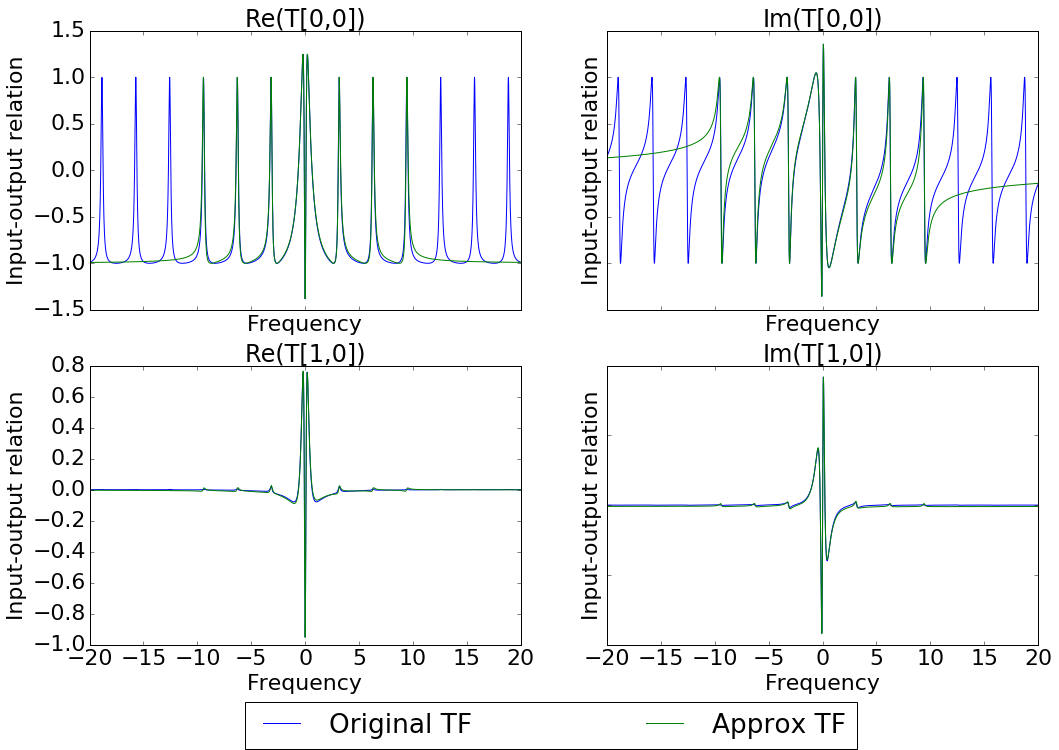

In [116]:

xr = numpy.linspace(-20,20,5001)
xr_im = xr*1j
yr = numpy.array(map(T_tilde, xr_im))
zr = numpy.array(map(T_fact, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(17,11))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )


f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

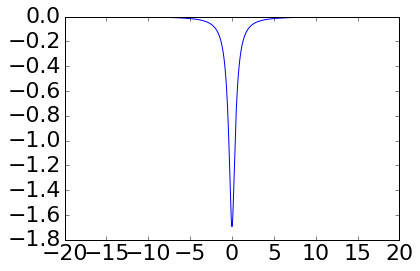

In [111]:
# Analysis of squeezing spectrum.

PP = get_squeezed_spectrum(yr)
plt.plot(xr, -PP)

## Impulse response

 (0, 10000),

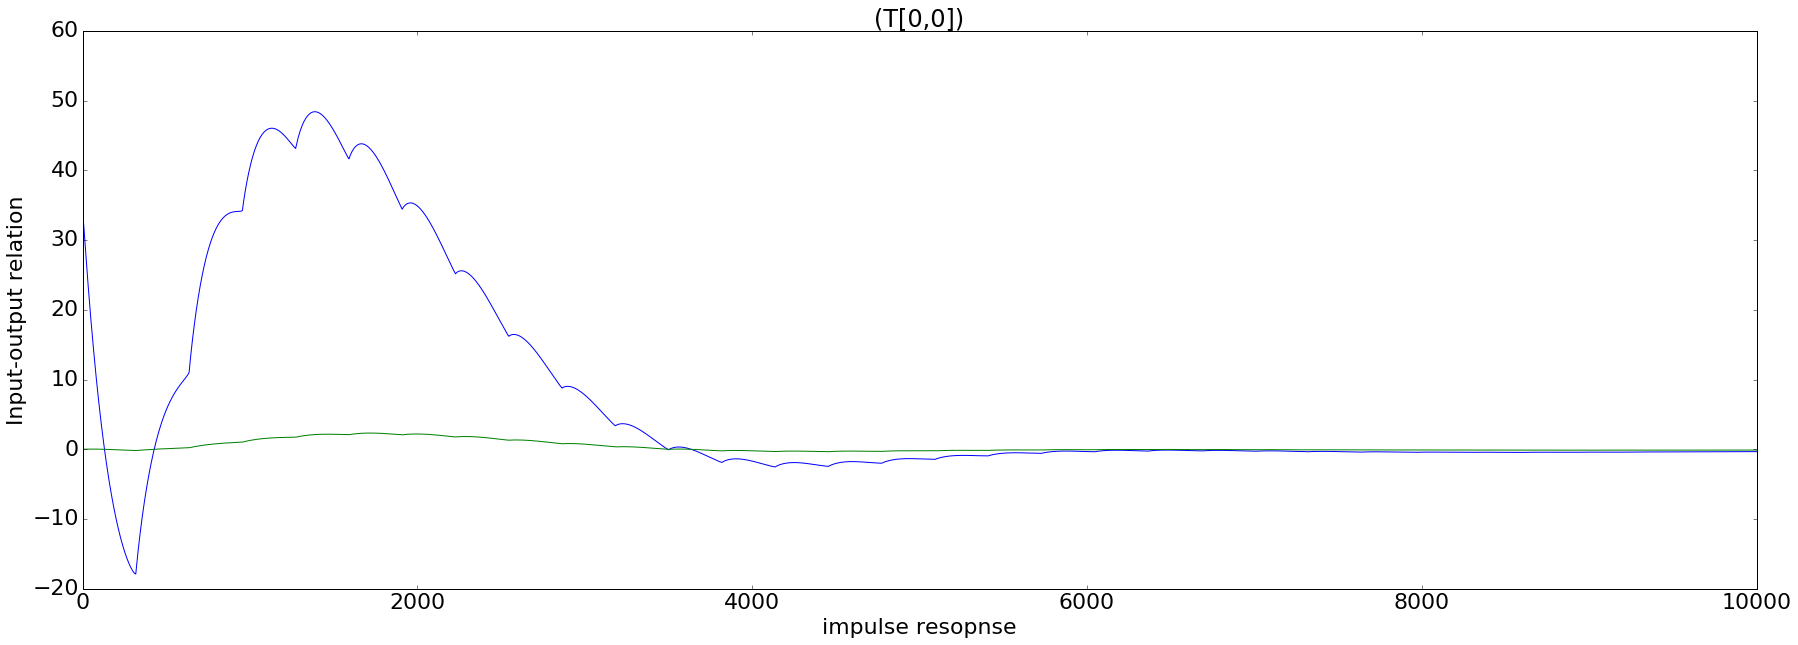

In [119]:
def get_PP(T, xr = numpy.linspace(-20,20,501), theta=0.):
    zr = np.array([T_tilde(x) for x  in xr*1j])
    PP = get_squeezed_spectrum(zr)
    return xr, PP


from scipy.fftpack import fft

xr = numpy.linspace(0,1000,100001)
_, PP = get_PP(T, xr)

# imp_yr = numpy.fft.fft(yr, axis=0)
imp_PP = fft(PP, axis=0)

f, ax = plt.subplots(figsize=(30,10))

l1, = ax.plot(imp_PP.real)
l2, = ax.plot(imp_PP.imag)
ax.set_title('(T[0,0])',fontsize= 24)


ax.set(xlabel='impulse resopnse', ylabel='Input-output relation', xlim=(0,10000))
